***FCIM.FIA - Fundamentals of Artificial Intelligence***

> **Lab 4:** *Learning* \\
> **Performed by:** *Bajenov Sevastian*, group *FAF-213* \\
> **Verified by:** Elena Graur, asist. univ.

## Imports and Utils

Create a virtual environment, install all the necessary dependencies so that you can run the notebook using your virtual environment as a kernel.

In [1]:
# pip install -r requirements.txt

## Task 1

In this laboratory work the main source of analysis was the provided `data.csv` file. It was necessary to perform dataset analysis and present some statistics. The dataset contained a table with the information about employees and their salaries. The list of columns and their order is the following: `Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status` (in this exact way they are presented in the csv file).

First of all, the task was to extract the most "valuable" columns out of the dataset, because further tasks implied predicting the value of a certain column, most probably representing the total pay for an employee (`TotalPay` or `TotalPayBenefits`). For data processing and visualization I was using `pandas` and `matplotlib` modules so that I could easily analyze the dataframes obtained from the dataset. I started by investigating the evolution of salaries within the range of time stated by the `Year` column. Clearly, the `TotalPayBenefits` value increased significantly especially within the 2011-2012 period, therefore the `Year` column has influence on the final salary for the employess and can be considered to predict it.

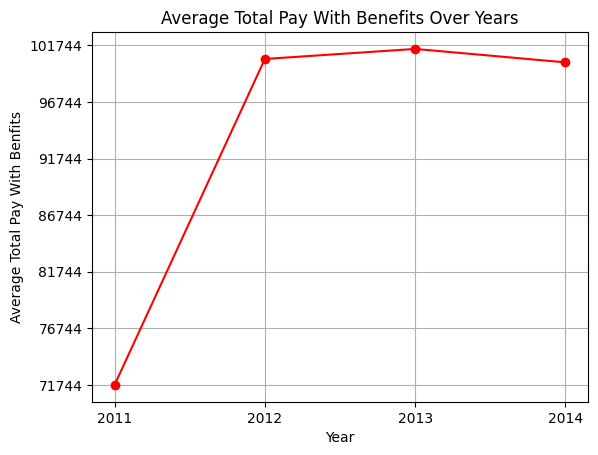

In [115]:
import pandas as pd
import numpy as np

df = pd.read_csv("data.csv", low_memory=False)

average_pay_per_year = df.groupby("Year")["TotalPayBenefits"].mean()
plot = average_pay_per_year.plot(kind="line", title="Average Total Pay With Benefits Over Years", grid=True, color="red", marker="o")

plot.set_xticks(average_pay_per_year.index);

plot.set_ylabel("Average Total Pay With Benfits");
plot.set_yticks(np.arange(average_pay_per_year.min(), average_pay_per_year.max() + 1000, 5000));


Another important aspect of defining the final value of `TotalPayBenefits` are the weights of each of its summation terms: `BasePay, OvertimePay, OtherPay and Benefits`. The situation with the first term is very clear, every employee in the dataset has the `BasePay` set to a non-zero value. However, the latter 3 columns are not assigned any value for certain employees, therefore the next plot visualizes the percentage of people, who actually have `OvertimePay, OtherPay and Benefits` set to a positive value. By looking at the results it can be clearly observed that the highest weights (impact on the `TotalPayBenefits`) have the `OtherPay and Benefits` among these 3 columns.

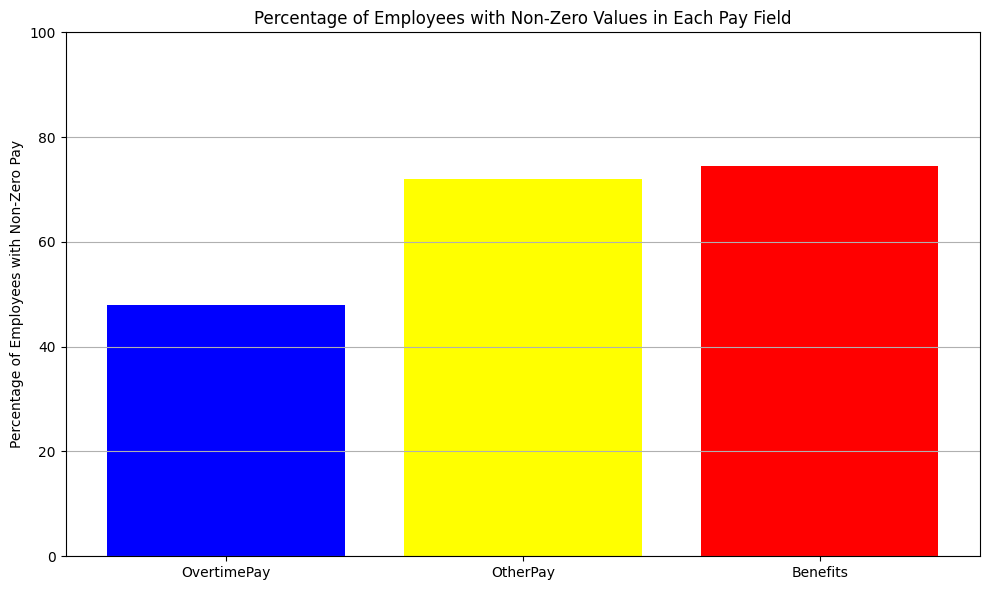

In [118]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data.csv", low_memory=False)

pay_columns = ["OvertimePay", "OtherPay", "Benefits"]

for column in pay_columns:
    df[column] = pd.to_numeric(df[column], errors="coerce")

nonzero_percentages = {}
for column in pay_columns:
    non_zero_count = (df[column] > 0).sum()
    total_count = len(df[column])
    nonzero_percentages[column] = (non_zero_count / total_count) * 100

nonzero_percentages_df = pd.DataFrame(list(nonzero_percentages.items()), columns=["PayType", "Percentage"])

plt.figure(figsize=(10, 6))
plt.bar(nonzero_percentages_df["PayType"], nonzero_percentages_df["Percentage"], color=["blue", "yellow", "red"])
plt.xlabel("")
plt.ylabel("Percentage of Employees with Non-Zero Pay")
plt.title("Percentage of Employees with Non-Zero Values in Each Pay Field")
plt.ylim(0, 100)
plt.grid(axis="y")

plt.tight_layout()
plt.show()

As an intermediary step in analyzing the dataset I decided to present top 10 job titles with the highest `TotalPayBenefits` value. I consider the `JobTitle` column to be important in the further prediction of the total pay value, therefore the employees with the job titles listed below have the highest probability of getting higher salaries even though they may not receive all the pay types analyzed before.

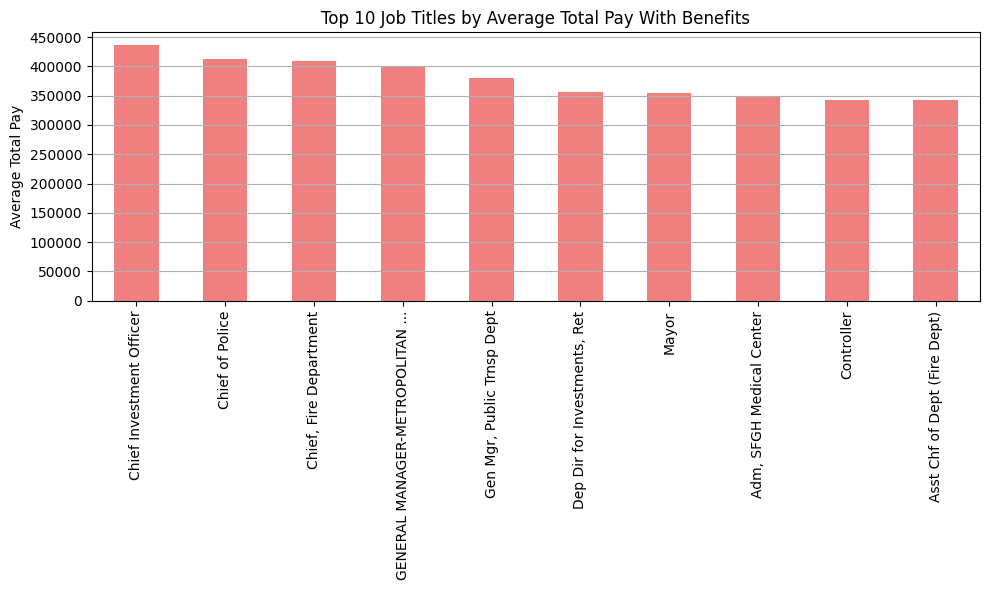

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def truncate_label(label, max_length=32):
    return label if len(label) <= max_length else label[:max_length-3] + '...'

df = pd.read_csv("data.csv", low_memory=False)

top_jobs_by_total_pay = df.groupby("JobTitle")["TotalPayBenefits"].mean().nlargest(10)

plt.figure(figsize=(10, 6))
plot = top_jobs_by_total_pay.plot(kind="bar", title="Top 10 Job Titles by Average Total Pay With Benefits", color='lightcoral')

xlabels = [truncate_label(label) for label in top_jobs_by_total_pay.index]
plot.set_xticklabels(xlabels)
plot.set_xlabel("")
plot.set_yticks(np.arange(0, top_jobs_by_total_pay.max() + 50000, 50000))
plot.set_ylabel("Average Total Pay")

plt.grid(axis='y')
plt.tight_layout()
plt.show()

Back in the second plot I demonstrated the impact of each of the pay types on the final value of `TotalPayBenefits`. In that scenario I calculated the percentage of employees who actually have each of the pay types present. Now, however, I would like to show another relevant plot which demonstrates the actual percentage of each pay type in the `TotalPayBenefits` column. Clearly, the `BasePay` and `Benefits` have the highest contribution once again but in this scenario `OtherPay` and `OvertimePay` become almost insignificant in comparison to the former ones. That is why their weights should be minimal when predicting employee's `TotalPayBenefits`.

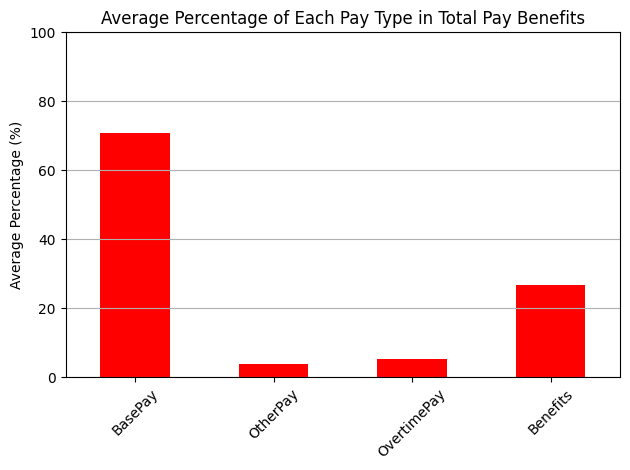

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def truncate_label(label, max_length=32):
    return label if len(label) <= max_length else label[:max_length-3] + '...'

df = pd.read_csv("data.csv", low_memory=False)

pay_columns = ["BasePay", "OtherPay", "OvertimePay", "Benefits"]
for column in pay_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

average_percentages = {}
for column in pay_columns:
    average_percentages[column] = (df[column].mean() / df["TotalPayBenefits"].mean()) * 100

percentage_df = pd.DataFrame(list(average_percentages.items()), columns=["Pay Type", "Average Percentage"])
percentage_df.set_index("Pay Type", inplace=True)

plot = percentage_df.plot(kind="bar", legend=False, title="Average Percentage of Each Pay Type in Total Pay Benefits", color="red")
plot.set_xlabel("")
plot.set_ylabel("Average Percentage (%)")
plot.set_ylim(0, 100)
plt.xticks(rotation=45)

plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Task 2

`Linear regression` is a type of a `supervised machine-learning algorithm` that learns from the labelled datasets and maps the data points to the most optimized linear functions, which can be used for prediction on new datasets. In our case the labelled dataset is represented by the `data.csv` file. In the previous section I discovered that certain columns from the dataset may influence the outcome of the variable to be predicted: `TotalPayBenefits`. `BasePay, OvertimePay, OtherPay and Benefits` should be considered anyway while they are directly proportional to the `TotalPayBenefits`. Among the `JobTitle` and `Year`, however, I decided to choose `Year` because it is presented as a number, does not require conversion and is more predictable. It could be possible to convert the `JobTitle` to a mean value of `TotalPayBenefits` but further investigations showed that this approach does not lead to any good results. Moreover, `JobTitle` is an example of categorical data but when using `linear regression` we usually make predictions on continuous data.

In the code below I used the features selected before and performed `LinearRegression` (using `scikit-learn` module) on them in order to obtain coefficients for each feature. The test set and the training set were divided in the 40/60% proportion in order to obtain the best results. An important remark: if the values for a feature column is not present, it is excluded from regression analysis.

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

df = pd.read_csv("data.csv", low_memory=False)

columns = ["Year", "BasePay", "OtherPay", "OvertimePay", "Benefits"]
for column in columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

df.dropna(subset=columns, inplace=True)

features = df[["BasePay", "OvertimePay", "OtherPay", "Benefits", "Year"]]
target = df["TotalPayBenefits"]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.4, random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)

for feature, coef in zip(features.columns, model.coef_):
    print(f"{feature}: {coef}")

BasePay: 1.0000000000000038
OvertimePay: 0.9999999999999993
OtherPay: 0.9999999999999976
Benefits: 1.000000000000003
Year: 6.3074086409956e-13


The results obtained after training and testing the model are pretty accurate. All types of pay coefficients are almost equal to 1 which is true as they are directly proportional to the target variable, and the year coefficient is also very small but has its impact on the final result. It is worth mentioning that when I tested the contribution of the `JobTitle` feature to the final prediction, its coefficient was much smaller. Although both `Year` and `JobTitle` may be neglected, I decided to leave `Year` in the equation.

## Task 3

The `Linear Regression Model` presented in the previous task is actually called `Ordinary Least Squares` and its main idea is adjusting the slope of the resulting plane in the way to minimize the sum of squared residuals for all the independent variables participating. I said plane and not line because the predicted `TotalPayBenefits` variable is dependent on multiple parameters and therefore the plane should be used to suit all the data points. The squared residuals define nothing else but the difference between the predicted data and actual data (variance) when performing linear regression.

There are multiple enhanced linear regression models to choose from but I decided to test `Elastic Net Regularization` and `Least-angle Regression`. The main reason why I did not choose `Ridge` or `Lasso` regression is that they are mainly used when the training set is too small and we want to avoid overfitting. In our case the dataset is large enough to split it into decent training and testing sets. 

`Elastic Net Regularization` is more flexible in this situation, as it combines the `Ridge` and `Lasso` regressions. It basically applies two penalties to the sum of squared residuals: ridge penalty to the squared slope and lasso penalty to the absolute value of slope. `l1_ratio` parameter is used to control the contribution of each regression type and `alpha` is nothing else but the penalty coefficient.

`Least-angle regression (LARS)` has its own advantages. One of them is efficient handling of correlating data. The idea behing this regularization algorithm is that when two or more independent variables correlate, the algorithm picks the solution path such that it is equiangular between the features. It also works great when the number of features is much higher than the number of data samples.

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, Lars

def print_model_results(model, model_name):
    print(f"\n{model_name} Results:")

    for feature, coef in zip(features.columns, model.coef_):
        print(f"{feature}: {coef}")

df = pd.read_csv("data.csv", low_memory=False)

columns = ["Year", "BasePay", "OtherPay", "OvertimePay", "Benefits"]
for column in columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

df.dropna(subset=columns, inplace=True)

features = df[["BasePay", "OvertimePay", "OtherPay", "Benefits", "Year"]]
target = df["TotalPayBenefits"]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.4, random_state=42)

ols_model = LinearRegression()
ols_model.fit(x_train, y_train)

elastic_net_model = ElasticNet(alpha=0.2, l1_ratio=0.5)
elastic_net_model.fit(x_train, y_train)

lars_model = Lars()
lars_model.fit(x_train, y_train)

print_model_results(ols_model, "OLS")
print_model_results(elastic_net_model, "Elastic Net")
print_model_results(lars_model, "LARS")


OLS Results:
BasePay: 1.0000000000000038
OvertimePay: 0.9999999999999993
OtherPay: 0.9999999999999976
Benefits: 1.000000000000003
Year: 6.3074086409956e-13

Elastic Net Results:
BasePay: 1.000044673739465
OvertimePay: 1.0000113892654432
OtherPay: 0.999989439766492
Benefits: 0.9998829248733779
Year: -0.0

LARS Results:
BasePay: 1.000000000000006
OvertimePay: 1.0000000000000022
OtherPay: 0.9999999999999991
Benefits: 0.999999999999981
Year: 0.0


Both `Elastic Net` and `LARS` regressions show better results than the initial `Ordinary Least Squares` method by neglecting the `Year` feature which has minimum impact on the prediction result. In terms of time performance during training and testing phases the models seem to be equally fast.

## Task 4

In order to evaluate the performance of the models I decided to use 2 main regression metrics: `Root Mean Squared Error (RMSE)` and `Mean Absolute Error (MAE)` (both of them work with the difference between the testing data and predicted data). The former one is based on the `Mean Squared Error (MAE)` which is marked as deprecated in the sklearn.metrics module. Its idea is to evaluate the average value of the squared errors, whereas the `RMSE` performs an addition square root operation on the resulting value. This way the metric is sensitive to outliers but at the same time remains in the original units of the target variable. On the other hand, `MAE` deals with the average absolute value of the error and demonstrates general accuracy of the model.

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, Lars
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

def evaluate_errors(model_name, test, pred):
    rmse = root_mean_squared_error(test, pred)
    mae = mean_absolute_error(test, pred)
    print(f"\n{model_name} Errors:")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}\n")

df = pd.read_csv("data.csv", low_memory=False)

columns = ["Year", "BasePay", "OtherPay", "OvertimePay", "Benefits"]
for column in columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

df.dropna(subset=columns, inplace=True)

features = df[["BasePay", "OvertimePay", "OtherPay", "Benefits", "Year"]]
target = df["TotalPayBenefits"]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.4, random_state=42)

ols_model = LinearRegression()
ols_model.fit(x_train, y_train)

elastic_net_model = ElasticNet(alpha=0.2, l1_ratio=0.2)
elastic_net_model.fit(x_train, y_train)

lars_model = Lars()
lars_model.fit(x_train, y_train)

ols_pred = ols_model.predict(x_test)
elastic_net_pred = elastic_net_model.predict(x_test)
lars_pred = lars_model.predict(x_test)

evaluate_errors("OLS", y_test, ols_pred)
evaluate_errors("Elastic Net", y_test, elastic_net_pred)
evaluate_errors("LARS", y_test, lars_pred)


OLS Errors:
RMSE: 2.0746463730578193e-10
MAE: 1.6539425622809752e-10


Elastic Net Errors:
RMSE: 0.2833814740855709
MAE: 0.20806475268694477


LARS Errors:
RMSE: 1.158769607132567e-10
MAE: 9.058308651261522e-11



The results may seem not obvious but they can be explained. All 3 models perform at a decent level with a minimum error, however `OLS` and `LARS` errors are significantly lower than for the `Elastic Net`. This happens because the `OLS` and `LARS` do not apply regularization and thus no additional variance is introduced. The dataset is large enough and therefore L1 and L2 regularization incorporated into `Elastic Net` spoils overall performance. However, it is possible to make `Elastic Net` performance better in terms of errors. If we reduce the influence of `L1 regularization` influence the error is going to be smaller, but it is still higher than for `OLS` and `LARS`.

## Task 5-6

The final analysis which can be performed on the dataset is `Cluster analysis`. `Clustering` aims at forming groups of homogeneous data points from a heterogeneous dataset. It evaluates the similarity based on a metric like `Manhattan distance`, for example, and then groups the points with highest similarity score together. 

In order to perform clustering I was using the `K-Means Clustering` algorithm. It assigns data points to one of the K clusters depending on their distance from the center of the clusters. It starts by randomly assigning the clusters centroid in the space. Then each data point assign to one of the cluster based on its distance from centroid of the cluster. After assigning each point to one of the cluster, new cluster centroids are assigned. This process runs iteratively until it finds good cluster.

For the process of clustering I removed the target column from the dataset (`TotalPayBenefits`) and considered only the most influencial features: `BasePay`, `OvertimePay`, `OtherPay` and `Benefits`. The feature data was then scaled to correspond to the Gaussian distribution. In order to plot the resulting clusters I applied the `Principal Component Analysis (PCA)` to the rescaled feature dataframe. This was necessary to reduce data dimensionality (having 4 features I reduced them to 2 principal components in order to present the clusters on a plane plot). The contribution of features in each of the principal components as well as the data clusters are presented below.

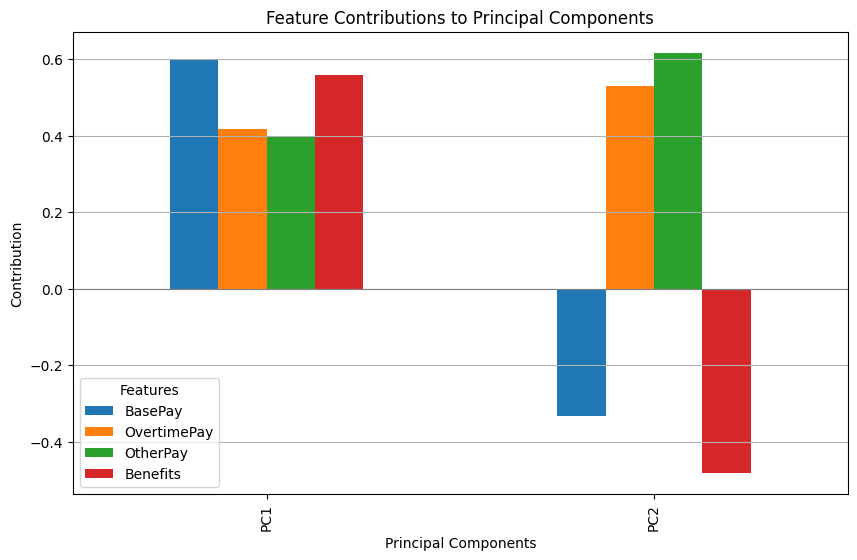

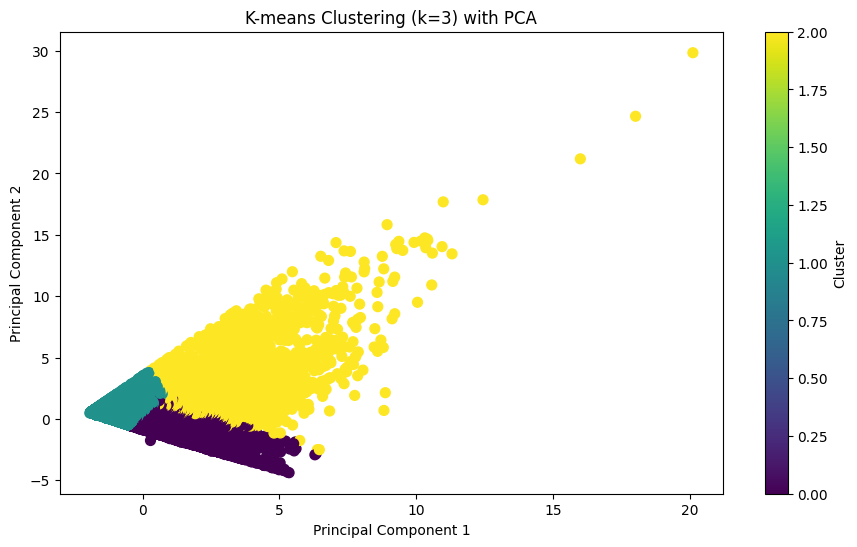

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

df = pd.read_csv("data.csv", low_memory=False)

features = df[["BasePay", "OvertimePay", "OtherPay", "Benefits"]]

features = features.apply(pd.to_numeric, errors='coerce').fillna(0)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df['Cluster']

df['PC1'] = principal_components[:, 0]
df['PC2'] = principal_components[:, 1]

feature_contributions = pd.DataFrame(pca.components_, columns=features.columns, index=['PC1', 'PC2'])
feature_contributions.plot(kind='bar', figsize=(10, 6))

plt.title("Feature Contributions to Principal Components")
plt.ylabel("Contribution")
plt.xlabel("Principal Components")
plt.axhline(0, color='grey', lw=0.8)
plt.grid(axis='y')
plt.legend(title="Features")
plt.show()

plt.figure(figsize=(10.7, 6))
plt.scatter(df['PC1'], df['PC2'], c=df['Cluster'], cmap='viridis', marker="o", s=50)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-means Clustering (k=3) with PCA")
plt.colorbar(label="Cluster")
plt.show()

## Conclusions:

## Acknowledgements


## Bibliography:

1. https://www.geeksforgeeks.org/ml-linear-regression/
2. https://trendspider.com/learning-center/linear-regression-intercept-predicting-future-values-and-trends/
3. https://scikit-learn.org/1.5/modules/linear_model.html
4. https://medium.com/@hannah.hj.do/getting-to-know-lars-least-angle-regression-f50e94c34b97
5. https://scikit-learn.org/1.5/api/sklearn.metrics.html#module-sklearn.metrics
6. https://www.geeksforgeeks.org/clustering-in-machine-learning/
7. https://www.geeksforgeeks.org/k-means-clustering-introduction/
8. https://scikit-learn.org/1.5/api/sklearn.cluster.html